In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import gamma, binom
from scipy.sparse import diags
from scipy.sparse.linalg import spsolve
from scipy.optimize import fsolve
from tqdm.auto import tqdm
from scipy.sparse import diags, kron, block_diag
import pandas as pd

def set_power_exact_solution(x, p, alpha):
    y = gamma(1+p)/gamma(1+p-alpha) * x**(p-alpha)
    return y

def set_traveling_wave_exact_solution(x, t, alpha, eps):
    if alpha == 1:
        coef_x = np.sqrt(2)/(4*eps)
        coef_t = -3/4
        y = (1-np.tanh( coef_x*x + coef_t*t ))/2
    else:
        coef_x = np.sqrt(2)/(4*eps)
        coef_t = -3/(4*gamma(1+alpha))
#         coef_t = -3/(4*alpha)
        y = (1-np.tanh( coef_x*x + coef_t*t**alpha ))/2
    return y

def set_coef(terminate_point, alpha, method='L1'):
    """Set the coefficient of fractional scheme:

    Parameters
    ----------
    terminate_point : int
        The number of coefficient.
    alpha : float
        The fractional order between (0,1).
    method : str 
        The coefficient of scheme to generate.
        (defualt is 'L1')
        possible options : 'L1', 'GL'.

    Returns
    -------
    1D array
        The coefficient array generated 
        based on the selected method.
        
    """
    
    if method == 'L1':
        coef = [(j)**(1-alpha) - (j-1)**(1-alpha) \
                for j in range(1, terminate_point+1)]
    elif method == 'GL':
        coef = [(-1)**(j) * binom(alpha, j) \
                for j in range(0, terminate_point+1)]
        
    return np.array(coef)

def set_Laplacian1D(nx, dx):
    # central differece
    diagonals = [np.ones(nx-1), -2*np.ones(nx-1), np.ones(nx-1)]
    offsets = [-1, 0, 1]
    L = diags(diagonals, offsets, shape=(nx-1, nx-1), format='csr')
    L[0,-1] = L[-1,0] = 1
    return L / dx**2

def set_Dirichlet(nx, dx):
    # central differece
    diag = -2*np.ones(nx)
    diag[0] = diag[-1] = -1
    off_diag = np.ones(nx)
    
    diagonals = [off_diag, diag, off_diag]
    offsets = [-1, 0, 1]
    L = diags(diagonals, offsets, shape=(nx, nx), format='csr')
    return L / dx**2

def compute_classical_energy(u, epsilon, dx):
    ux = np.gradient(u)/dx
    term1 = np.sum((epsilon**2 / 2.0) * (ux**2))
    term2 = np.sum(((1 - u ** 2) ** 2) / 4)
    return dx * (term1 + term2)


def set_boundary(u, BC):
    if BC == 'neumann':
        # set top, botton, left, right
        u[0, 1:-1] = u[1, 1:-1]
        u[-1, 1:-1] = u[-2, 1:-1]
        u[1:-1, 0] = u[1:-1, 1]
        u[1:-1, -1] = u[1:-1 ,-2]

        # set the corner
        u[0, 0] = u[1, 1]
        u[-1, -1] = u[-2, -2]
        u[-1, 0] = u[-2, 1]
        u[0, -1] = u[1, -2]
    elif BC == 'dirichlet':
        u[0, :] = 0
        u[:, 0] = 0
        u[-1, :] = 0
        u[:, -1] = 0
        
    return u

def set_Laplacian2D(Nx, h, BC='periodic'):
    """Set the 2D discrete laplacian by central difference:
        Neumann boundary laplacian is discreted by 
        
        x-direction : u_{-1,j,k}=u_{0,j,k} and
                      u_{Nx+1,j,k}=u_{0,j,k}
                          
        y-direction : u_{i,-1,k}=u_{i,0,k} and
                      u_{i,Nx+1,k}=u_{i,0,k}
            
        Built by two block matries and two off-diagnoals, 
        corner block (corB), central block (cenB)
            
        The diagonal block is [corB, cenB, ..., cenB, corB]
        The off-diagnoals are diagonals line below (above) 
        the main diagonal by Nx positions, all consisting of 1.
            
        L = diagonal block + off-diagonals

    Parameters
    ----------
    Nx : int
        The number of mesh grids.
    h : float
        The mesh size.
    BC : str
        The boundary condition. (default is 'periodic')
        possible options : 'periodic', 'dirichlet', 'nuemann'

    Returns
    -------
    2D array
        The discrete laplacian with certain boundary.
        
    """
    if BC == 'periodic':
        diag = np.ones(Nx)
        L = diags([diag, -2*diag, diag, 1, 1], \
                  [-1, 0, 1 , -Nx+1, Nx-1], shape=(Nx, Nx))
        I = diags(diag, shape=(Nx, Nx))
    
        L = kron(L, I) + kron(I, L)
    elif BC == 'dirichlet'
        diag = np.ones(Nx)
        L = diags([diag, -2*diag, diag], \
                  [-1, 0, 1], shape=(Nx, Nx))
        I = diags(diag, shape=(Nx, Nx))
    
        L = kron(L, I) + kron(I, L)
    elif BC == 'neumann':
        # bulid the block
        diag_cor = 3*np.ones(Nx)
        diag_cor[0] = diag_cor[-1] = 2

        diag_cen = 4*np.ones(Nx)
        diag_cen[0] = diag_cen[-1] = 3

        off_I = diags([np.ones(Nx**2), np.ones(Nx**2)], \
                      [Nx,-Nx], shape=(Nx**2, Nx**2))

        corB = diags([np.ones(Nx), -diag_cor, np.ones(Nx)], \
                     [-1, 0, 1], shape=(Nx, Nx))

        cenB = diags([np.ones(Nx), -diag_cen, np.ones(Nx)], \
                     [-1, 0, 1], shape=(Nx, Nx))

        diagBs = [cenB for i in range(Nx-2)]
        diagBs = tuple([corB]+diagBs+[corB])

        L = block_diag(diagBs) + off_I
        
    return L / h**2

def set_eps(m, h):
    """ Set the interface width:
    
    Parameters
    ----------
    m : int
        The number of grid points 
        in the transition layer.
    h : float
        The mesh size.

    Returns
    -------
    float
        The interface width base m and h .
        
    """
    return h*(m+1)/4/np.sqrt(2)/np.arctanh(0.8)

SyntaxError: invalid syntax (74606088.py, line 147)

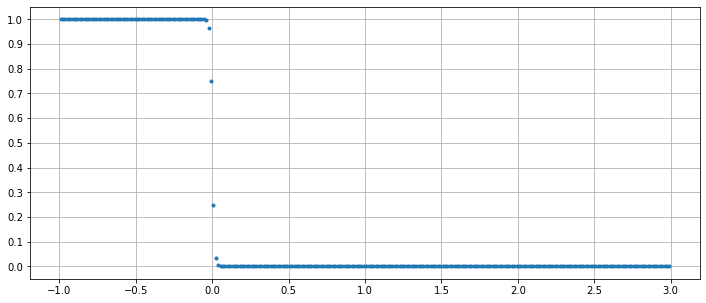

In [7]:
Nx = 256
h = 4/Nx
x = np.linspace(-1+h/2, 3-h/2, Nx)
eps = set_eps(1,h)
plt.figure(figsize=(12,5))
plt.yticks(np.arange(0, 11, 0.1))
plt.grid()
plt.plot(x, (1-np.tanh( x/2/np.sqrt(2)/eps ))/2, '.')

In [41]:
Nx = 256
h = 4/Nx
# set_eps(8,h)
dt = 1e-2

h**2 > dt*2*set_eps(4,h)

True

In [9]:
# test for first order in time
# Based on "An unconditionally gradient stable numerical method for solving the Allen–Cahn equation"


alpha_list = [1, 0.9, 0.7, 0.5, 0.3, 0.1]
# alpha_list = [0.1, 0.3, 0.5, 0.7, 0.9]
# alpha_list = [0.3, 0.5]


# plt.figure(figsize=(12,5))
# plt.plot(x, u0, '-.')

data_dict = {alpha: [] for alpha in alpha_list}

Nx = 256
h = 4/Nx

eps = set_eps(1,h)
dt = 1e-2
Nt = 2000
x = np.linspace(-1+h/2, 3-h/2, Nx)
u0 = (1-np.tanh( x/2/np.sqrt(2)/eps ))/2

Lap = set_Dirichlet(Nx, h)
I = diags(np.ones(Nx), shape=(Nx, Nx))

bdy = np.zeros(Nx)
# bdy[0] = eps**2/h**2

t = np.linspace(0, Nt) * dt

idx_time = [int(Nt/4), int(Nt/2), int(3*Nt/4), Nt]

for alpha in alpha_list:
    print(f"alpha: {alpha}")
    
    pbar = tqdm(total=Nt)
    
    u_historyArray = np.array([u0])
    u = u0.copy()
    
    if alpha == 1:
        # solved by classical allen cahn
        H = (2+1/dt) * I - eps**2 * Lap

        for i in range(Nt):
            b = (3+1/dt)*u - u**3 + bdy
            u = spsolve(H, b)
            u_historyArray = np.vstack([u_historyArray, u])
            pbar.update(1)


    else:
#         L1_coef = set_coef(Nt, alpha, 'L1') / dt**alpha
#         H = (L1_coef[0]+2) * I - eps**2 * Lap
        GL_coef = set_coef(Nt, alpha, 'GL') / dt**alpha
        H = (GL_coef[0]+2) * I - eps**2 * Lap

        for i in range(Nt):
            
            if i == 0: # first iteration u_1
#                 b =  (3 + L1_coef[0])*u0 - u0**3 + bdy
                b =  (3 + GL_coef[0])*u0 - u0**3 + bdy
                u = spsolve(H, b)
            else:
#                 u_nonlocalDiff = np.flipud(np.diff(u_historyArray, axis=0))
#                 u_nonlocal = L1_coef[1:i+1].dot(u_nonlocalDiff)
                u_nonlocalDiff = np.flipud(u_historyArray[1:]-u0)
                u_nonlocal = GL_coef[1:i+1].dot(u_nonlocalDiff)

#                 b = (3+L1_coef[0])*u - u**3 - u_nonlocal + bdy
                b = 3*u - u**3 - u_nonlocal + GL_coef[0]*u0 + bdy
                u = spsolve(H, b)

            u_historyArray = np.vstack([u_historyArray, u])
            pbar.update(1)
    
    pbar.close()
    data_dict[alpha] = u_historyArray


alpha: 1


  0%|          | 0/2000 [00:00<?, ?it/s]

alpha: 0.9


  0%|          | 0/2000 [00:00<?, ?it/s]

alpha: 0.7


  0%|          | 0/2000 [00:00<?, ?it/s]

alpha: 0.5


  0%|          | 0/2000 [00:00<?, ?it/s]

alpha: 0.3


  0%|          | 0/2000 [00:00<?, ?it/s]

alpha: 0.1


  0%|          | 0/2000 [00:00<?, ?it/s]

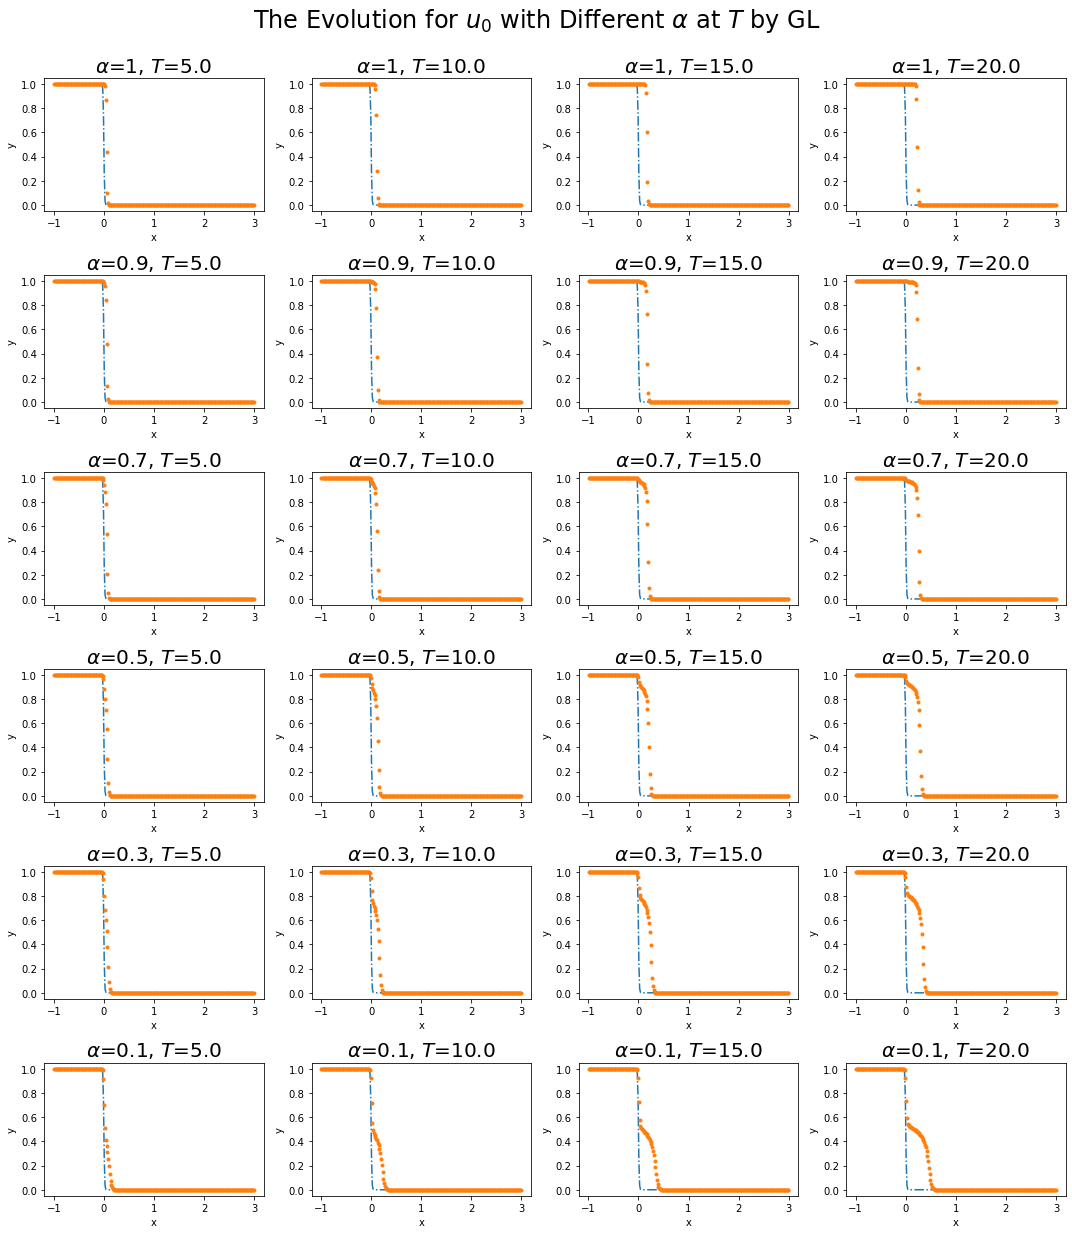

In [10]:
fig, ax = plt.subplots(len(alpha_list), len(idx_time), figsize=(15, 18))
i, j = 0, 0

for alpha in alpha_list:
    j = 0
    for idx_t in idx_time:
        ax[i][j].plot(x, u0, '-.')
        ax[i][j].plot(x, data_dict[alpha][idx_t],'.')
        ax[i][j].set_title(rf'$\alpha$={alpha}, $T$={idx_t*dt}', fontsize=20)
        ax[i][j].set_xlabel('x')
        ax[i][j].set_ylabel('y')
        j = j+1
    i = i+1

fig.suptitle(r'The Evolution for $u_0$ with Different $\alpha$ at $T$ by GL', fontsize=24)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

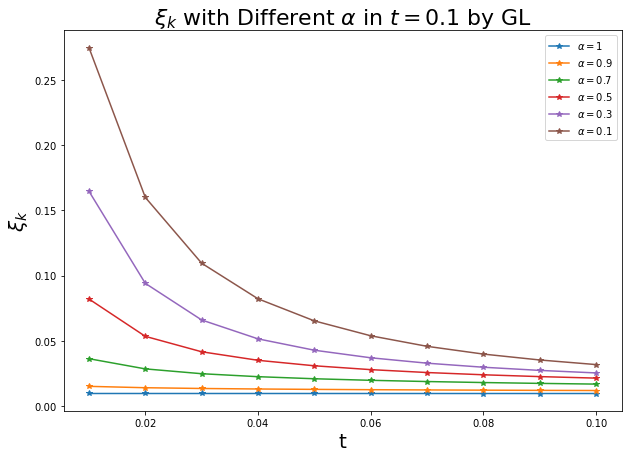

In [18]:
# array_filter = data_dict[0.5][100]!=1.0 & data_dict[0.5][100]!=0
# np.extract(data_dict[0.5][100]!=1.00000000e+000, data_dict[0.5][100])
plt.figure(figsize=(10, 7))

t = np.linspace(1, Nt, Nt) * dt
for alpha in alpha_list:
    mass_list = [np.sum(_) for _ in np.diff(data_dict[alpha], axis=0)]
    plt.plot(t[:10], mass_list[:10],'*-')
    


plt.legend([r"$\alpha=$"+f"{alpha}" for alpha in alpha_list])
plt.title(r'$\xi_k$ with Different $\alpha$ in $t=0.1$ by GL', fontsize=22)
plt.ylabel(r'$\xi_k$', fontsize=20)
plt.xlabel('t', fontsize=20)
plt.show()

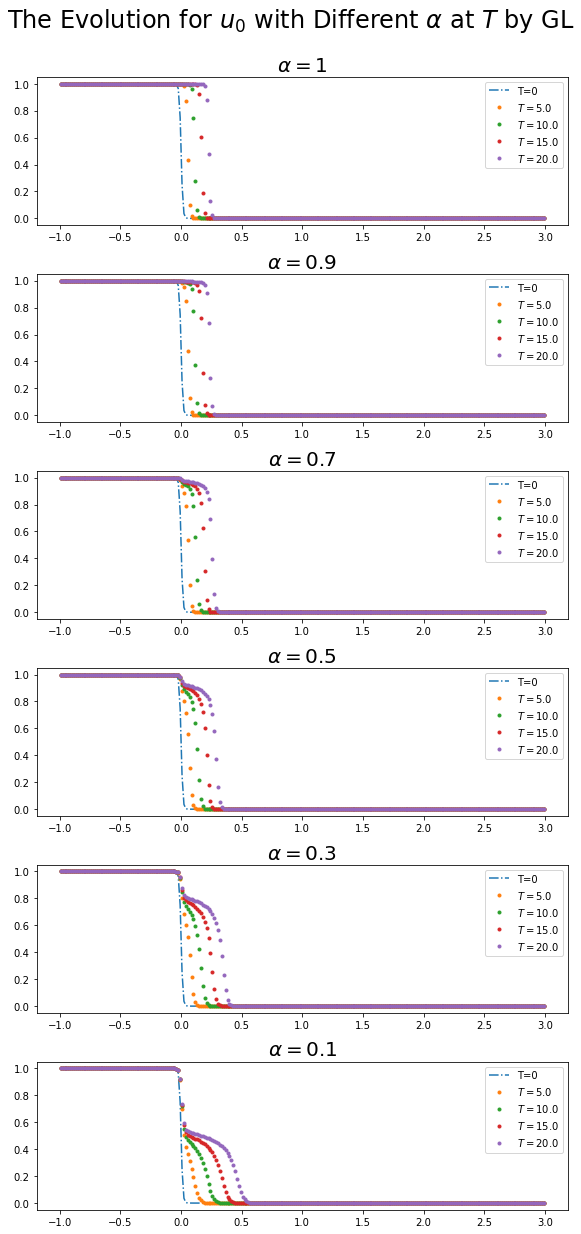

In [11]:
wave_t = np.linspace(0, Nt, 5, dtype=int)[1:]
alpha_list = [1, 0.9, 0.7, 0.5, 0.3, 0.1]

fig, ax = plt.subplots(len(alpha_list),1, figsize=(8,18))
i = 0
for alpha in alpha_list:
    ax[i].plot(x, data_dict[alpha][0], '-.')
    for tt in wave_t:
        ax[i].plot(x, data_dict[alpha][tt], '.')
    ax[i].legend([r"T=0"]+[r"$T=$"+f"{tt*dt}" for tt in wave_t])
    ax[i].set_title(r"$\alpha=$"+f"{alpha}", fontsize=20)
    i = i+1
    
fig.suptitle(r'The Evolution for $u_0$ with Different $\alpha$ at $T$ by GL', fontsize=24)
plt.tight_layout(rect=[0, 0.03, 1, 0.98])
plt.show()

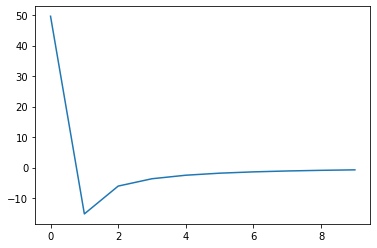

In [252]:
plt.plot(mass_list[:10])
plt.show()

In [5]:
# test for the source term
def set_source(x, t, eps, alpha):
    if alpha == 1:
        term1 = 3*t**2*np.sin(2*np.pi*x)
    else:
        term1 = (gamma(4)/gamma(4-alpha)) * t**(3-alpha) * np.sin(2*np.pi*x)
    term2 = eps**2 * 4*np.pi**2 * np.sin(2*np.pi*x) * t**(3-alpha)
    term3 = t**3*np.sin(2*np.pi*x)
    term4 = ( t**3*np.sin(2*np.pi*x) )**3
    return term1 + term2 - term3 + term4
def exact_with_source(x, t):
    return t**3*np.sin(2*np.pi*x)

In [12]:
dx = 1/128
T = 1
Nt = 2**0 * 10**3
dt = T/Nt
eps = 0.015

alpha_list = [0.1, 0.3, 0.5, 0.7, 0.9, 1]
# alpha_list = [0.1]

error_dict = {alpha: [] for alpha in alpha_list}

dx**2 > dt * 2 * eps

True

In [13]:
# test for first order in time
# Based on "An unconditionally gradient stable numerical method for solving the Allen–Cahn equation"

# nList = [7, 8, 9, 10]
nList = [0, 1, 2, 3]
# nList = [7, 8, 9]
# alpha = 0.1
# errors = []

for alpha in alpha_list:
    print(f"alpha: {alpha}")
    for n in nList:
        print(f"n: {n}")
        dx = 1/128
    #     dx = 2**(1-n)
        Nx = int(1/dx)

        eps = 1e-4

        x = np.linspace(0, 1, Nx)
        u0 = exact_with_source(x, 0)
    #     u0 = np.tanh(x)
    #     u0 = 0.05*(2*np.random.rand(Nx)-1)
    #     T = 1/s
        T = 1
    #     dt = (dx/(16*s))*0.1
    #     dt = dx/2**6
    #     dt = dx**2
    #     T = 100
    #     dt = 1/(2**n * 10**4)
    #     dt = 0.5
        Nt = 2**(n) * 10**3
        dt = T/Nt

        Lap = set_Dirichlet(Nx, dx)
        I = diags(np.ones(Nx-2), shape=(Nx-2, Nx-2))

        bdy = np.zeros(Nx-2)
    #     bdy[0] = eps**2/dx**2

#         EList = []
        u = u0.copy()
        dt_equiv = dt*eps**2/(dt+eps**2)
    #     print(f"Eps^2: {eps**2}\n")
#         print(f"Final Time: {T}\n")
#         print(f"Number of spatial mesh points: {Nx}\n")
#         print(f"Number of temporal mesh points: {Nt}\n")
#         print(f"Mesh size in time: {dt}, Mesh size in space: {dx}\n")
    #     print(f"Equiv dt: {dt_equiv}\n")
#         energy = []
#         plt.figure(figsize=(12,5))
#         plt.plot(x, u0, '-.')
        u_historyArray = np.array([u0])

        pbar = tqdm(total=Nt)
        if alpha == 1:
            # solved by classical allen cahn
            H = (2+1/dt) * I - eps**2 * Lap

            for i in range(Nt):
                source = set_source(x,i*dt,eps, alpha)
                u_intor = u[1:-1].copy()
                b = (3+1/dt)*u_intor - u_intor**3 + bdy + source[1:-1]
                u[1:-1] = spsolve(H, b)
                u[0] = 0
                u[-1] = 0
                u_historyArray = np.vstack([u_historyArray, u])
                pbar.update(1)

        else:
#             L1_coef = set_coef(Nt, alpha, 'L1') / dt**alpha / gamma(2-alpha)
            GL_coef = set_coef(Nt, alpha, 'GL') / dt**alpha
            H = (GL_coef[0]+2) * I - eps**2 * Lap
#             H = (L1_coef[0]+2) * I - eps**2 * Lap

            for i in range(Nt):
                u_intor = u[1:-1].copy()
                source = set_source(x,(i+1)*dt, eps, alpha)
    #             source = np.random.rand(Nx)
                if i == 0: # first iteration u_1
                    b =  (3 + GL_coef[0])*u_intor - u_intor**3 + bdy + source[1:-1]
#                     b =  (3 + L1_coef[0])*u_intor - u_intor**3 + bdy + source[1:-1]
                    u[1:-1] = spsolve(H, b)
                else:
                    u_nonlocalDiff = np.flipud(u_historyArray[1:,1:-1]-u0[1:-1])
                    u_nonlocal = GL_coef[1:i+1].dot(u_nonlocalDiff)
#                     u_nonlocalDiff = np.flipud(np.diff(u_historyArray[:,1:-1], axis=0))
#                     u_nonlocal = L1_coef[1:i+1].dot(u_nonlocalDiff)

                    b = 3*u_intor - u_intor**3 - u_nonlocal + GL_coef[0]*u0[1:-1] + bdy + source[1:-1]
#                     b = (3 + L1_coef[0])*u_intor - u_intor**3 - u_nonlocal + bdy + source[1:-1]
                    u[1:-1] = spsolve(H, b)
                u[0] = 0
                u[-1] = 0
                u_historyArray = np.vstack([u_historyArray, u])
#                 energy.append(compute_classical_energy(u, eps, dx))
                pbar.update(1)

                if i*dt > 1 :
                    print(f't: {i*dt}')
    #                 plt.plot(x, u)
    #                 plt.show()


        pbar.close()
        u_exact = exact_with_source(x, T)
        E = np.linalg.norm(u-u_exact, 2) / np.sqrt(Nx)
#         EList.append(E)
#         plt.plot(x, u,'.')
#         plt.plot(x, u_exact, '+')
#         plt.legend(['inital', 'numerical', 'exact'])
#         plt.show()
#         t_list = np.linspace(0, Nt, Nt) * dt
#         plt.plot(t_list, energy)
#         plt.show()
#         print(f'Error: {E}\n')
#         print(f"log(Error): {np.log2(E)}\n")
    #     print('End Run\n')
    #     print(t)

#         errors.append(E)
        error_dict[alpha].append(E)
# for i in range(len(errors)-1):
#     print('order: ', np.log2(errors[i][-1]/errors[i+1][-1]))

alpha: 0.1
n: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

n: 1


  0%|          | 0/2000 [00:00<?, ?it/s]

n: 2


  0%|          | 0/4000 [00:00<?, ?it/s]

n: 3


  0%|          | 0/8000 [00:00<?, ?it/s]

alpha: 0.3
n: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

n: 1


  0%|          | 0/2000 [00:00<?, ?it/s]

n: 2


  0%|          | 0/4000 [00:00<?, ?it/s]

n: 3


  0%|          | 0/8000 [00:00<?, ?it/s]

alpha: 0.5
n: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

n: 1


  0%|          | 0/2000 [00:00<?, ?it/s]

n: 2


  0%|          | 0/4000 [00:00<?, ?it/s]

n: 3


  0%|          | 0/8000 [00:00<?, ?it/s]

alpha: 0.7
n: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

n: 1


  0%|          | 0/2000 [00:00<?, ?it/s]

n: 2


  0%|          | 0/4000 [00:00<?, ?it/s]

n: 3


  0%|          | 0/8000 [00:00<?, ?it/s]

alpha: 0.9
n: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

n: 1


  0%|          | 0/2000 [00:00<?, ?it/s]

n: 2


  0%|          | 0/4000 [00:00<?, ?it/s]

n: 3


  0%|          | 0/8000 [00:00<?, ?it/s]

alpha: 1
n: 0


  0%|          | 0/1000 [00:00<?, ?it/s]

n: 1


  0%|          | 0/2000 [00:00<?, ?it/s]

n: 2


  0%|          | 0/4000 [00:00<?, ?it/s]

n: 3


  0%|          | 0/8000 [00:00<?, ?it/s]

In [88]:
from pathlib import Path
import json

initialName = 'exact'

rootPath = Path('./data/') / initialName / 'allen-cahn'

# print(rootPath.exists())

if rootPath.exists() is False:
    rootPath.mkdir(parents=True)

info_dict = {
    'Nx': Nx,
    'dx': dt,
    'iteration': Nt,
    'boundary': 'dirichlet',
    'eps': eps
}
    
errorPath = rootPath / 'error_L1.json'
infoPath = rootPath / 'info.json'
errorPath.write_text(json.dumps(error_dict))
infoPath.write_text(json.dumps(info_dict))

86

In [15]:
import pandas as pd
df = pd.DataFrame(error_dict)
print(df)
# print(df.to_latex())

        0.1       0.3       0.5       0.7       0.9       1.0
0  0.004815  0.002990  0.002151  0.001489  0.000865  0.002641
1  0.002405  0.001495  0.001076  0.000745  0.000433  0.001321
2  0.001202  0.000747  0.000538  0.000373  0.000217  0.000661
3  0.000601  0.000374  0.000269  0.000186  0.000108  0.000330


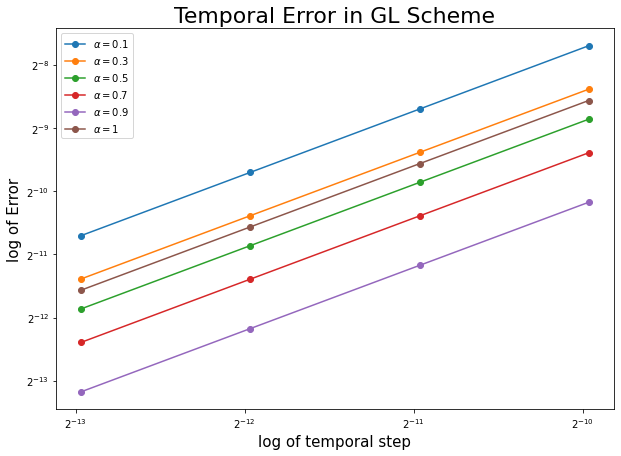

In [16]:
# plt.plot(np.log2([2**(1-n) for n in nList]), np.log2(errors), '*-')
fig, ax = plt.subplots(figsize = (10, 7))
for alpha, errors in error_dict.items():

    plt.loglog([1/(2**(n)*10**3) for n in nList], errors, 'o-')
    ax.set_xscale("log", base=2)
    ax.set_yscale("log", base=2)
    plt.title('Temporal Error in GL Scheme', fontsize=22)
    plt.xlabel('log of temporal step', fontsize=15)
    plt.ylabel('log of Error', fontsize=15)

plt.legend([r"$\alpha=$"+f"{alpha}" for alpha in alpha_list])
plt.show()

# plt.plot(np.log2([2**(-5), 2**(-6), 2**(-7), 2**(-8)]), np.log2(errors), '*-')
# plt.title(r'log-log plot $\alpha$=0.7')
# plt.xlabel(r'$\log_2{(N_x)}$')
# plt.ylabel(r'$\log_2{(Error)}$')
# plt.show()

In [1]:
# 2-D 
# test for the source term
def set_source(x, y, t, eps, alpha):
    if alpha == 1:
        term1 = 3*t**2*np.sin(2*np.pi*(x+y))
    else:
        term1 = (gamma(4)/gamma(4-alpha)) * t**(3-alpha) * np.sin(2*np.pi*(x+y))
    term2 = eps**2 * 4*np.pi**2 * np.sin(2*np.pi*(x+y)) * t**(3-alpha)
    term3 = t**3*np.sin(2*np.pi*(x+y))
    term4 = ( t**3*np.sin(2*np.pi*(x+y)) )**3
    return term1 + term2 - term3 + term4
def exact_with_source(x, y, t):
    return t**3*np.sin(2*np.pi*(x+y))

# alpha_list = [0.1, 0.3, 0.5,  0.7, 0.9, 1]
alpha_list = [0.1]
power_list = [0, 1, 2, 3]

Nx = 128
h = 1/128
T = 1
Nt = 2**1 * 10**3
dt = T/Nt
eps = 0.0005

BC = 'dirichlet'
L = 1

x = np.linspace(h/2, L-h/2, Nx)
y = np.linspace(h/2, L-h/2, Nx)

if BC == 'periodic':
    x = x[:-1]
    y = y[:-1]
    I = diags(np.ones((Nx-1)**2), shape=((Nx-1)**2, (Nx-1)**2))
elif BC == 'neumann' or 'dirichlet':
    I = diags(np.ones((Nx)**2), shape=((Nx)**2, (Nx)**2))

# set the discrete laplacian
Lap = set_Laplacian2D(Nx, h, BC)
    
# set the 2D mesh grid by x and y
X, Y = np.meshgrid(x, y)

# # set the 2D mesh grid by x and y
# x0 = np.linspace(0, L, Nx+2)
# y0 = np.linspace(0, L, Nx+2)
# X0, Y0 = np.meshgrid(x0, y0)

u0 = np.zeros((Nx+2, Nx+2))
u0[1:-1, 1:-1] = exact_with_source(X, Y ,0)
u0 = set_boundary(u0, BC)

NameError: name 'np' is not defined

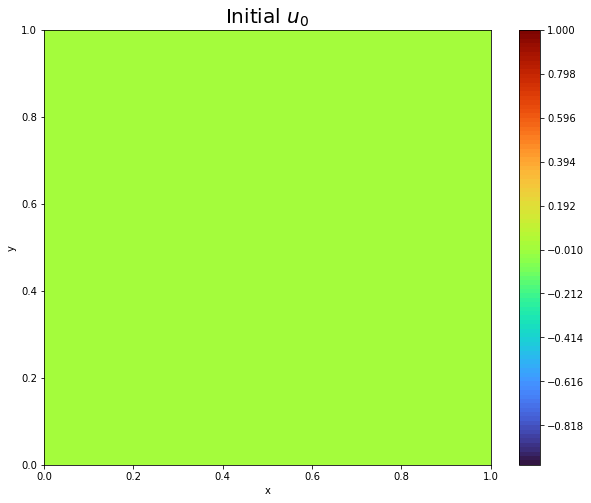

In [48]:
plt.figure(figsize=(10,8))
plt.contourf(X0,Y0, u, cmap="turbo", levels=np.linspace(-1,1,100))
plt.colorbar()
plt.title(r'Initial $u_0$', fontsize=20)
plt.xlabel('x')
plt.ylabel('y')
plt.show()

In [58]:
for alpha in alpha_list:
    print(f"alpha: {alpha}")
    
    # inital the history array
    u_historyArray = u0.copy().reshape(1, Nx+2, Nx+2)
    u = u0.copy()
    
    pbar = tqdm(total=Nt)
    
    if alpha == 1:
        # solved by classical allen cahn
        H = (2+1/dt) * I - eps**2 * Lap
        
        for i in range(Nt):
            u_interior = u[1:-1, 1:-1].copy().flatten()
            source = set_source(X, Y,(i+1)*dt, eps, alpha)
            b = (3+1/dt)*u_interior - u_interior**3 + source.flatten()
            u[1:-1, 1:-1] = np.reshape(spsolve(H, b), (Nx, Nx))
            u = set_boundary(u, BC)
            u_historyArray = np.vstack([u_historyArray, u.reshape(1, Nx+2, Nx+2)])
            pbar.update(1)
        
    else:
        L1_coef = set_coef(Nt, alpha, 'L1')/ dt**alpha / gamma(2-alpha)
        H = (L1_coef[0]+2) * I - eps**2 * Lap
        
        for i in range(Nt):
            u_interior = u[1:-1, 1:-1].copy().flatten()
            source = set_source(X, Y, (i+1)*dt, eps, alpha)
            if i == 0: # first iteration u_1
                b =  (3 + L1_coef[0])*u_interior - u_interior**3
                u[1:-1, 1:-1] = np.reshape(spsolve(H, b), (Nx, Nx))
                u = set_boundary(u, BC)
            else:
                u_nonlocalDiff = np.flipud(np.diff(u_historyArray[:, 1:-1, 1:-1], axis=0))
                u_nonlocal = np.tensordot(L1_coef[1:i+1], u_nonlocalDiff, axes=1)
        
                b = (3 + L1_coef[0])*u_interior - u_interior**3 - u_nonlocal.flatten() + source.flatten()
                u[1:-1, 1:-1] = np.reshape(spsolve(H, b), (Nx, Nx))
                u = set_boundary(u, BC)
            
    
            u_historyArray = np.vstack([u_historyArray, u.reshape(1, Nx+2, Nx+2)])
            pbar.update(1)
    
    
    u_exact = np.zeros((Nx+2, Nx+2))
    u_exact[1:-1, 1:-1] = exact_with_source(X, Y ,T)
    E = np.linalg.norm(u.flatten()-u_exact.flatten(), 2) / np.sqrt((Nx+2)**2)
    print(E)
#     EList.append(E)
    # plot the energy for k=0,...,N_t
    
    pbar.close()

alpha: 0.1


  0%|          | 0/2000 [00:00<?, ?it/s]

0.002433888669672417


In [60]:
u_exact = np.zeros((Nx+2, Nx+2))
u_exact[1:-1, 1:-1] = exact_with_source(X, Y ,T)
E = np.linalg.norm(u.flatten()-u_exact.flatten(), 2) / np.sqrt((Nx+2)**2)
np.log2(E)

-7.6825211064974095